## VGG Net
의의 <br>
> 1) Alex Net(conv net기반 model의 전성기를 열은 network)이후 conv net기반 model의 layer를 깊게 쌓을수록 성능이 좋아질 것이라는 예측을 실험적으로 보임 <br>
> 2) 작은 kernel_size (3x3)를 이용하여 model의 성능을 끌어올림 <br>

paper: https://arxiv.org/pdf/1409.1556.pdf <br>
ref(how to make VGG with PyTorch, youtuber: Aladdin Persson): <br>
 https://www.youtube.com/watch?v=ACmuBbuXn20&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=17 <br>


In [ ]:
from google.colab import drive
import sys
import os
from IPython import display
drive.mount('/content/drive')
FOLDERNAME = 'models_from_scratch'

sys.path.append('/contente/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/models_from_scratch


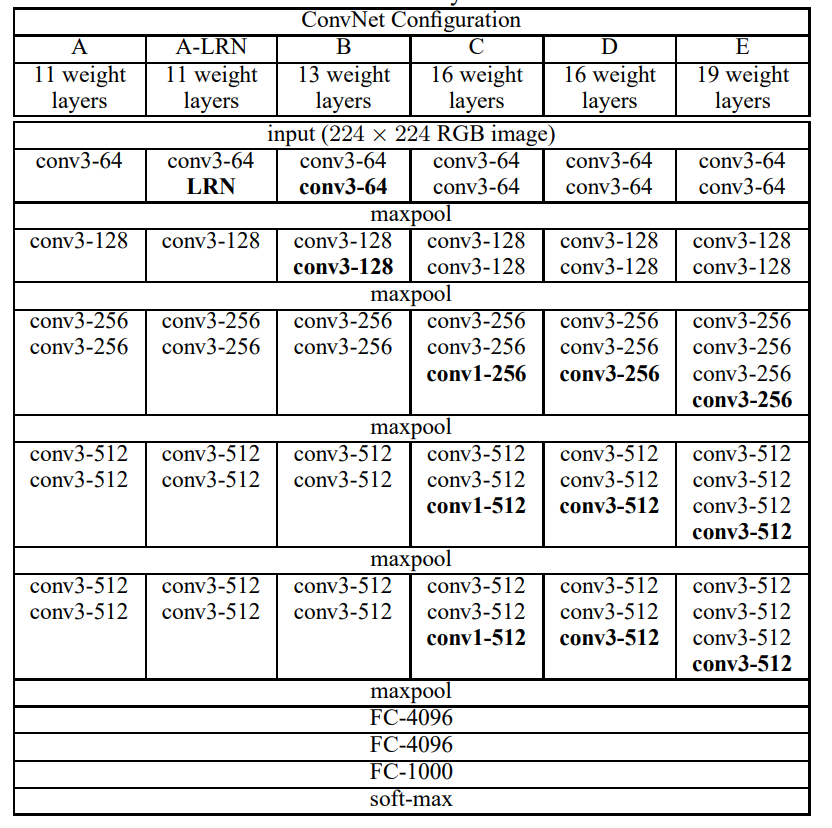

In [ ]:
# VGG architecture from VGG paper table 1
display.Image(os.path.join(os.getcwd(), 'pic/VGG.png'))

VGG net의 경우 여러 layer의 갯수에 따라 version이 있습니다. (11, 13, 16, 19) <br>
모든 conv net의 경우 kernel_size: 3x3, stride: 1, padding: 1로 고정입니다. <br>
(-> Height, Width 고정) <br>
다만, Max Pool layer를 거칠 때마다 Height와 Width가 각각 반으로 줄어듭니다.<br> (kernel_size: 2, stride: 2) <br>
table 1.을 보시면 저자가 왼쪽에서부터 오른쪽으로 새로운 layer가 추가(or 변경)되는 것에 대해 굵은 글씨체로 써줬으므로 version이 변경될 때마다 해당 layer만 신경쓰면 될 것 같습니다. <br>
cf) VGG16의 conv1(kernel_size: 1)의 경우 model 비교를 위해 저자가 설정한 것으로 생략하겠습니다. <br>
in spite of the same depth, the configuration C (which
contains three 1 × 1 conv. layers), performs worse than the configuration D, (6page)
```python
# psudo code
class VGG(version, ...):
  1) VGG_11을 설계한다.
  2) if version > 11:
    layer 추가
  3) if version > 13:
    layer 추가
  4) if version > 16:
    layer 추가
  5) if version == 19:
    layer 추가

  def forward(self, x):
    '''
    input:
      - x(Tensor[N, C, 224, 224])
    output:
      - logits(Tensor[N, num_classes])
    '''

```
그러면 VGG 11을 psudo code로 설계해봅시다.
```python
# psudo code
class VGG(nn.Module):
  def __init__(self, version, ...):
    super(VGG, self).__init__()
    self.block_1 = nn.Conv2d() C(3->64), depth: 1
    self.pool = nn.MaxPool2d() (Height, Width: 224 -> 112)

    self.block_2 = nn.Conv2d() C(64->128), depth: 1
    self.pool = MaxPool2d() (Height, Width: 112 -> 56)

    self.block_3 = nn.Conv2d() C(128->256) depth: 2
    self.pool = MaxPool2d() (Height, Width: 56 -> 28)

    self.block_4 = nn.Conv2d() C(256->512) depth: 2
    self.pool = MaxPool2d() (Height, Width: 28 -> 14)

    self.block_5 = nn.Conv2d() C(512->512) depth: 2
    self.pool = MaxPool2d() (Height, Width: 14 -> 7)

    self.linear_block = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features = 512*7*7(C*H*W), out_featuers = 4096),
      nn.Linear(in_features = 4096, out_featuers = 4096),
      nn.Linear(in_features = 4096, out_featuers = num_classes(1000)),
      nn.Softmax(dim = -1)
    )

  def forward(self, x):
    pass


```


In [ ]:
import torch
import torch.nn as nn

In [ ]:
class VGG(nn.Module):
  def __init__(self, version, in_channels, H, W):
    '''
    inputs:
      - verison(int): one of (11, 13, 16, 19)
      - in_channels: img channels (ex. RGB: 3)
      - H: img height
      - W: img width
    '''
    
    super().__init__()
    num_pool = 5
    self.block_1 = nn.ModuleList([
      nn.Conv2d(in_channels = in_channels, 
                            out_channels = 64, 
                            kernel_size = (3, 3),
                            stride = 1,
                            padding = 1),
     nn.MaxPool2d(kernel_size = (2, 2),
        stride = 2)                               
    ])
    if version > 11:
      self.block_1.insert(1, nn.Conv2d(in_channels = 64, 
                            out_channels = 64, 
                            kernel_size = (3, 3),
                            stride = 1,
                            padding = 1))

    self.block_2 = nn.ModuleList([
        nn.Conv2d(in_channels = 64,
                            out_channels = 128,
                            kernel_size = (3,3),
                            stride = 1,
                            padding = 1),
        nn.MaxPool2d(kernel_size = (2, 2),
              stride = 2)
    ])
    if version > 11:
      self.block_2.insert(1, nn.Conv2d(in_channels = 128,
                            out_channels = 128,
                            kernel_size = (3,3),
                            stride = 1,
                            padding = 1))
    
    self.block_3 = nn.ModuleList([
        nn.Conv2d(in_channels = 128,
                              out_channels = 256,
                            kernel_size = (3,3),
                            stride = 1,
                            padding = 1),
        nn.Conv2d(in_channels = 256,
                              out_channels = 256,
                              kernel_size = (3, 3),
                              stride = 1,
                              padding = 1),
        nn.MaxPool2d(kernel_size = (2, 2),
                               stride = 2)
    ])
    if version > 13:
      self.block_3.insert(2, nn.Conv2d(in_channels = 256,
                              out_channels = 256,
                              kernel_size = (3, 3),
                              stride = 1,
                              padding = 1))
    if version > 16:
      self.block_3.insert(3, nn.Conv2d(in_channels = 256,
                              out_channels = 256,
                              kernel_size = (3, 3),
                              stride = 1,
                              padding = 1))


    self.block_4 = nn.ModuleList([
        nn.Conv2d(in_channels = 256,
                            out_channels = 512,
                            kernel_size = (3,3),
                            stride = 1,
                            padding = 1),
        nn.Conv2d(in_channels = 512,
                                out_channels = 512,
                                kernel_size = (3,3),
                                stride = 1,
                                padding = 1),
        nn.MaxPool2d(kernel_size = (2, 2),
                               stride = 2)
    ])
    if version > 13:
      self.block_4.insert(2, nn.Conv2d(in_channels = 512,
                                out_channels = 512,
                                kernel_size = (3,3),
                                stride = 1,
                                padding = 1))
    if version > 16:
      self.block_4.insert(3, nn.Conv2d(in_channels = 512,
                                out_channels = 512,
                                kernel_size = (3,3),
                                stride = 1,
                                padding = 1))
    
    self.block_5 = nn.ModuleList([
        nn.Conv2d(in_channels = 512,
                              out_channels = 512,
                              kernel_size = (3, 3),
                              stride = 1,
                              padding = 1),
        nn.Conv2d(in_channels = 512,
                          out_channels = 512,
                          kernel_size = (3, 3),
                          stride = 1,
                          padding = 1),
        nn.MaxPool2d(kernel_size = (2, 2),
                    stride = 2)
    ])
    if version > 13:
      self.block_5.insert(2, nn.Conv2d(in_channels = 512,
                          out_channels = 512,
                          kernel_size = (3, 3),
                          stride = 1,
                          padding = 1))
    if version > 16:
      self.block_5.insert(2, nn.Conv2d(in_channels = 512,
                          out_channels = 512,
                          kernel_size = (3, 3),
                          stride = 1,
                          padding = 1))

    self.linear_block = nn.Sequential(
                                       nn.Flatten(),
                                       nn.Linear(in_features = 512*H//(2**(num_pool))*W//(2**(num_pool)),
                                                 out_features = 4096),
                                       nn.Linear(in_features = 4096,
                                                 out_features = 4096),
                                       nn.Linear(in_features = 4096,
                                                 out_features = 1000)
    )
            
  def forward(self, x):
    for module in self.block_1:
      x = module(x)
    print(x.size())

    for module in self.block_2:
      x = module(x)
    print(x.size())

    for module in self.block_3:
      x = module(x)
    print(x.size())

    for module in self.block_4:
      x = module(x)
    print(x.size())

    for module in self.block_5:
      x = module(x)
    print(x.size())

    x = self.linear_block(x)
    print(x.size())

In [ ]:
x = torch.randn(1, 3, 224, 224)
model = VGG(19, x.size(1), x.size(2), x.size(3))

In [ ]:
model

VGG(
  (block_1): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): ModuleList(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): ModuleList(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_4): ModuleList(
    (0

In [ ]:
model(x)

torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 7, 7])
torch.Size([1, 1000])
